In [254]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer

In [287]:
class myNN():
    def __init__(self, architecture, learning_rate):
        self.architecture = architecture
        self.learning_rate = learning_rate
        self.params = {}
        self.init_layers()
        self.train_loss_history = []
        self.test_loss_history = []
        
    def init_layers(self):
        #np.random.seed(99)
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            layer_input_size = layer['input_dim']
            layer_output_size = layer['output_dim']
            self.params['W' + str(layer_index)] = np.random.randn(layer_output_size, layer_input_size)*0.1
            self.params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1)*0.1
            #print(self.params['W'+str(layer_index)].shape)
            #print(self.params['W'+str(layer_index)])
            #print(self.params['b'+str(layer_index)])
            #print("*******")
            
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def relu(self, Z):
        return np.maximum(0,Z)
    
    def linear(self, Z):
        return Z
    
    def sigmoid_backward(self, dA, Z):
        sig = self.sigmoid(Z)
        return dA*sig*(1-sig)
    
    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        return dZ
    
    def linear_backward(self, dA, Z):
        return dA
    
    def single_layer_FP(self, A_prev, W_curr, b_curr, activation='relu'):
        #print(W_curr.shape)
        #print(A_prev.shape)
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        #print(Z_curr.shape)
        #print("------")
        if activation == 'relu':
            activation_func = self.relu
        elif activation == 'sigmoid':
            activation_func = self.sigmoid
        elif activation == 'linear':
            activation_func = self.linear
        else:
            raise Exception('Non-supported activation function')
        return activation_func(Z_curr), Z_curr
    
    def forward_propagation(self, x):
        memory = {}
        A_curr = x
        for index, layer in enumerate(self.architecture):
            layer_index = index + 1
            A_prev = A_curr
            activation_func = layer['activation']
            W_curr = self.params['W'+str(layer_index)]
            b_curr = self.params['b'+str(layer_index)]
            A_curr, Z_curr = self.single_layer_FP(A_prev, W_curr, b_curr, activation_func)
            memory["A"+str(index)] = A_prev
            memory["Z"+str(layer_index)] = Z_curr
        return A_curr, memory
        
    def get_loss_value(self, y, y_predict):
        #delta = y - y_predict
        #loss = np.dot(delta, delta.T)
        #return np.squeeze(loss)
        return np.power(y_predict - y, 2).sum()
    
    def single_layer_BP(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
        if activation == 'relu':
            activation_func = self.relu_backward
        elif activation == 'sigmoid':
            activation_func = self.sigmoid_backward
        elif activation == 'linear':
            activation_func = self.linear_backward
        else:
            raise Exception('Non-supported activation function')
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dA_prev, dW_curr, db_curr
    
    def back_propagation(self, y_predict, y, memory):
        grads_values = {}
        dA_prev = 2*(y_predict-y)
        #dA_prev = delta * np.ones(y.shape).reshape(1,-1)
        for layer_prev_index, layer in reversed(list(enumerate(self.architecture))):
            layer_cur_index = layer_prev_index+1
            activation_func = layer['activation']
            dA_curr = dA_prev
            A_prev = memory['A' + str(layer_prev_index)]
            Z_curr = memory['Z' + str(layer_cur_index)]
            W_curr = self.params['W'+str(layer_cur_index)]
            b_curr = self.params['b'+str(layer_cur_index)]
            dA_prev, dW_curr, db_curr = self.single_layer_BP(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_func)
            grads_values['dW'+str(layer_cur_index)] = dW_curr
            grads_values['db'+str(layer_cur_index)] = db_curr
        return grads_values
    
    def update(self, grads_values):
        for index, layer in enumerate(self.architecture):
            layer_idx = index + 1
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size=16):
        for i in range(epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(0 ,x_train.shape[0], batch_size):
                start = j
                end = j+batch_size
                if end >= x_train.shape[0]:
                    end = x_train.shape[0]-1
                x_min = x_train[start:end]
                y_min = y_train[start:end]
                y_predict, memory = self.forward_propagation(x_min.T)
                loss = self.get_loss_value(np.array([y_min]), y_predict)
                grads_values = self.back_propagation(y_predict, np.array([y_min]), memory)
                self.update(grads_values)
            y_train_predict = self.predict(x_train.T)
            y_test_predict = self.predict(x_test.T)
            train_loss = self.get_loss_value(np.array([y_train]), y_train_predict)
            test_loss = self.get_loss_value(np.array([y_test]), y_test_predict)
            train_acc = self.accuracy(np.array([y_train]), y_train_predict)
            test_acc = self.accuracy(np.array([y_test]), y_test_predict)
            self.train_loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)
            if (i+1) % 100 == 0:
                print("Eposh : %4d/%d || training loss : %lf || training eval : %lf" % (i+1, epochs, train_loss, train_acc),end=" ")
                print("|| testing loss : %lf || testing eval : %lf" % (test_loss, test_acc))
    
    def show_parm(self):
        print(self.params)
    
    def accuracy(self, y, y_predict):
        power = np.power(y_predict - y, 2).mean()
        return np.sqrt(power)
    
    def predict(self, x):
        y_predict, memory = self.forward_propagation(x)
        return np.squeeze(y_predict)
    
    def get_loss_history(self):
        return self.train_loss_history, self.test_loss_history

In [288]:
def show_graph(d1, d2, labels, length = 0, locs='upper left'):
    t = range(len(d1))
    if length != 0:
        plt.plot(t[:length],d1[:length], 'r', label=labels[0])
        plt.plot(t[:length],d2[:length], 'b', label=labels[1])
    else:
        plt.plot(t, d1, 'r', label=labels[0])
        plt.plot(t, d2, 'b', label=labels[1])
    plt.legend(loc=locs)
    plt.show()

In [289]:
def my_split_function(data, label, test_size):
    random.seed(500)
    data, label = shuffle(data, label)
    train_len = int(len(data)*(1-test_size))
    return (data[:train_len], data[train_len:], label[:train_len], label[train_len:])

In [299]:
# https://quantdare.com/create-your-own-deep-learning-framework-using-numpy/
# https://www.itread01.com/feffx.html
# https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
nn_architecture = [
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001

In [300]:
# Orientation category : 2, 3, 4, 5
# Glazing Area Distribution : 0, 1, 2, 3, 4, 5
data = pd.read_csv('energy_efficiency_data.csv')
heating = data.pop('Heating Load')
cooling = data.pop('Cooling Load')

In [301]:
# for one hot encoding
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)

In [302]:
# split data
#data = Normalizer(norm='l1').fit_transform(data)
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)

In [303]:
model = myNN(nn_architecture, learning_rate)

In [304]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 19585.945977 || training eval : 5.831242 || testing loss : 7300.205582 || testing eval : 6.166190
Eposh :  200/2000 || training loss : 17247.777879 || training eval : 5.472116 || testing loss : 6262.981719 || testing eval : 5.711366
Eposh :  300/2000 || training loss : 17136.845064 || training eval : 5.454491 || testing loss : 6228.238284 || testing eval : 5.695502
Eposh :  400/2000 || training loss : 16986.327498 || training eval : 5.430484 || testing loss : 6192.357278 || testing eval : 5.679072
Eposh :  500/2000 || training loss : 16157.562827 || training eval : 5.296350 || testing loss : 5878.442125 || testing eval : 5.533253
Eposh :  600/2000 || training loss : 15535.492305 || training eval : 5.193394 || testing loss : 5659.158610 || testing eval : 5.429068
Eposh :  700/2000 || training loss : 14129.872641 || training eval : 4.952881 || testing loss : 5171.866090 || testing eval : 5.190068
Eposh :  800/2000 || training loss : 13187.792649 || tr

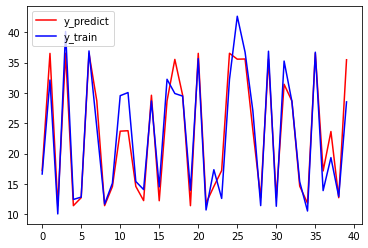

In [305]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'], 40)

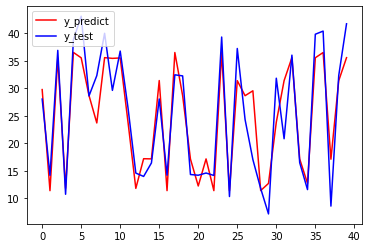

In [306]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'], 40)

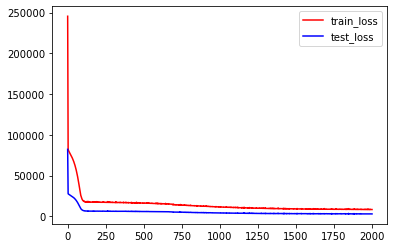

In [307]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')

In [308]:
# calculate correction
# we need to pop the categorical feature beacuse I think it can't be calculated with corr
data = pd.read_csv('energy_efficiency_data.csv')
data.pop('Orientation')
data.pop('Glazing Area Distribution')
data.corr()

,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Heating Load,Cooling Load
# Relative Compactness,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,-3.209966e-18,0.622272,0.634339
Surface Area,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,3.631399e-17,-0.658120,-0.672999
Wall Area,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,1.036064e-17,0.455671,0.427117
Roof Area,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,5.581108e-17,-0.861828,-0.862547
Overall Height,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,-2.481890e-18,0.889431,0.895785
Glazing Area,-3.209966e-18,3.631399e-17,1.036064e-17,5.581108e-17,-2.481890e-18,1.000000e+00,0.269841,0.207505
Heating Load,6.222722e-01,-6.581202e-01,4.556712e-01,-8.618283e-01,8.894307e-01,2.698410e-01,1.000000,0.975862
Cooling Load,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,2.075050e-01,0.975862,1.000000


In [309]:
# we choose higer corr such about Roof Area, Overall Height, Surface Aread
data.pop('# Relative Compactness')
data.pop('Wall Area')
data.pop('Glazing Area')
data.pop('Cooling Load')
print(data)
heating = data.pop('Heating Load')

     Surface Area  Roof Area  Overall Height  Heating Load
0           514.5     110.25             7.0         15.55
1           514.5     110.25             7.0         15.55
2           514.5     110.25             7.0         15.55
3           563.5     122.50             7.0         20.84
4           563.5     122.50             7.0         21.46
..            ...        ...             ...           ...
763         710.5     220.50             3.5         12.43
764         735.0     220.50             3.5         14.28
765         759.5     220.50             3.5         14.92
766         784.0     220.50             3.5         18.19
767         808.5     220.50             3.5         16.48

[768 rows x 4 columns]


In [310]:
nn_architecture = [
    {"input_dim": 3, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)
model = myNN(nn_architecture, learning_rate)

In [ ]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

Eposh :  100/2000 || training loss : 64843.287024 || training eval : 10.610144 || testing loss : 18319.458992 || testing eval : 9.768001
Eposh :  200/2000 || training loss : 20270.162838 || training eval : 5.932222 || testing loss : 6331.807630 || testing eval : 5.742662
Eposh :  300/2000 || training loss : 20041.360790 || training eval : 5.898646 || testing loss : 6260.428784 || testing eval : 5.710201
Eposh :  400/2000 || training loss : 20000.954607 || training eval : 5.892697 || testing loss : 6247.445963 || testing eval : 5.704277
Eposh :  500/2000 || training loss : 19890.786108 || training eval : 5.876446 || testing loss : 6211.379177 || testing eval : 5.687788
Eposh :  600/2000 || training loss : 19701.129370 || training eval : 5.848363 || testing loss : 6108.316877 || testing eval : 5.640403
Eposh :  700/2000 || training loss : 19420.935161 || training eval : 5.806626 || testing loss : 6014.023611 || testing eval : 5.596699
Eposh :  800/2000 || training loss : 19665.264074 || 

In [ ]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'], 40)

In [ ]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'], 40)

In [ ]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')

In [ ]:
# if we think the cacategorical features are also import feature
data = pd.read_csv('energy_efficiency_data.csv')
Orient = pd.get_dummies(data['Orientation'])
Glazing = pd.get_dummies(data['Glazing Area Distribution'])
data = pd.concat([data,pd.get_dummies(data['Orientation'], prefix='Orientation')],axis=1)
data = pd.concat([data,pd.get_dummies(data['Glazing Area Distribution'], prefix='Glazing Area Distribution')],axis=1)
data.drop(['Orientation'],axis=1, inplace=True)
data.drop(['Glazing Area Distribution'],axis=1, inplace=True)
data.pop('# Relative Compactness')
data.pop('Wall Area')
data.pop('Glazing Area')
data.pop('Cooling Load')
heating = data.pop('Heating Load')

In [ ]:
nn_architecture = [
    {"input_dim": 13, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "linear"},
]
learning_rate = 0.0000001
x_train, x_test, y_train, y_test = my_split_function(data.to_numpy(), heating.to_numpy(), test_size=0.25)
model = myNN(nn_architecture, learning_rate)

In [ ]:
model.train(x_train, np.array(y_train), x_test, np.array(y_test), 2000, batch_size=16)

In [ ]:
y_predict = model.predict(x_train.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_train, ['y_predict', 'y_train'], 40)

In [ ]:
y_predict = model.predict(x_test.T)
y_predict = np.squeeze(y_predict)
show_graph(y_predict, y_test, ['y_predict', 'y_test'], 40)

In [ ]:
train_loss, test_loss = model.get_loss_history()
t = range(len(train_loss))
show_graph(train_loss, test_loss, ['train_loss', 'test_loss'], locs='upper right')